# Tarea 4

Cuentas con un set de datos de imágenes en blanco y negro (de 28x28 pixeles) de distintas prendas de vestir (son 10 tipos de prendas en total, mira [aca](https://github.com/zalandoresearch/fashion-mnist)). En esta tarea vas a resolver el problema de crear nuevas imágenes prendas de vestir. Especificamente, la tarea que se te ha encomendado es:

> Elige dos tipos de los 10 tipos de prendas
>>Para cada uno de esos dos tipos, escribe una función que retorne uno de esos dos tipos, y retorne una nueva imagen de ese tipo, obtenida al azar, que no esté ya en el dataset

La solución a trabajar para escribir esta funcion consta de las siguientes partes

### Parte 1: datos, reducción de dimensionalidad

- Prueba dos formas de reducir a 6 dimensiones: PCA y autoencoders. 
- Busca 3 imágenes en el dataset. Para esas tres imágenes, compara visualmente lo que ocurre al (1) graficar la imagen original (hay código para eso más abajo) y (2) tomar el vector de la imagen, codificarlo, decodificarlo y volver a graficar (para pca y autoencoder, recuerda estandarizar y luego des-estandarizar, como hicimos en el notebook de compresión de la semana 9). 
- Sigue afinando tu método de reducción hasta que entregue imágenes que al codificar/decodificar, la imagen nueva resultante todavía guarde alguna semejanza con la realidad. 
- Una vez que estés satisfecho, transforma todo el dataset con tu método de reducción. Al dataset resultante (ahora con 6 dimensiones) le llamaremos **Xreducido**

### Parte 2: clustering y sampling 

- Ejecuta un algoritmo de clustering GMM sobre **Xreducido**, con 10 clústeres. Averigua como obtener las medias y las covarianzas de los 10 clústeres resultantes. 
- Usa *np.random.multivariate_normal(mean_vector,covariance_matrix)*, que se usa para obtener un elemento de la normal multivariada con su vector de media *mean_vector* y matriz de covarianzas *covariance_matrix*, para obtener un sample de cada una de las 10 gaussianas que entrenó tu GMM

### Parte 3: análisis  

- Cada sample puede ser graficado como imagen: hay que pasarlo por el decodificador (o la transformada inversa en el caso de PCA). 
- Analiza visualmente dos samples de cada clase
- Analiza visualmente la media de cada cluster identificado por GMM
- Con las visualizaciones de esta parte, responde: ¿qué clústeres parece entregar consistentemente prendas de un tipo en específico? ¿qué prendas son?
- Entrena un clasificador de randomforest con los datos originales. 
- Samplea y decodifica 50 ejemplos de cada cluster identificado por GMM, y entrégaselos al randomforest. Ahora ve los resultados de las predicciones. Vé si son consistentes en el sentido de que predicen que una buena cantidad de los ejemplos de los dos clústeres que identificaste son de una prenda en particular. 

### Detalles académicos

La entrega de esta tarea es el Viernes 19 de Noviembre, a las 20:00, por cuestionario en SIDING. Se debe subir solo un archivo de jupyter notebook. Te pedimos también por favor nombrar tu archivo con el formato **NumeroAlumno_Apellido_Nombre**. 

## Datos

In [4]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.datasets import fetch_openml

Bajamos el dataset, nos quedamos con 10.000 tuplas (esto es opcional, para que todo cargue más rápido, mientras más tuplas se dejen, mejor deberían ser los resultados)

In [46]:
mnist = fetch_openml('Fashion-MNIST', version=1, as_frame=True)
mnist.keys()

X, y = mnist['data'], mnist['target']
X_sample = X[60000:]
y_sample = y[60000:]
X_sample.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 60000 to 69999
Columns: 784 entries, pixel1 to pixel784
dtypes: float64(784)
memory usage: 59.8 MB


### Mostrando una foto
Para mostrar las fotos, tenemos que volver a formato de 28x28 píxeles

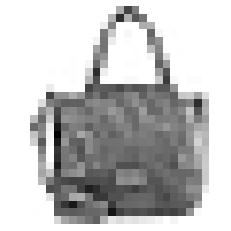

In [6]:
#sacar la entidad numero 2000 del dataset 

some_garment = X_sample.iloc[2000]
some_garment_image = some_garment.values.reshape(28,28)

plt.imshow(some_garment_image, cmap='binary')
plt.axis('off')
plt.show()

# ACA COMIENZA TU TRABAJO

In [79]:
print(mnist.keys())
num_dimensiones = len(X_sample.columns)

dict_keys(['data', 'target', 'frame', 'categories', 'feature_names', 'target_names', 'DESCR', 'details', 'url'])


# Parte 1: reducir dimensionalidad
¡Recuerda estandarizar los datos!

Autoencoders

In [63]:
from sklearn.decomposition import PCA
from tensorflow import keras
from sklearn.preprocessing import StandardScaler

def autoencoderdata(X_sample):
    sc = StandardScaler()
    X_std = sc.fit_transform(X_sample)

    num_dimensiones = len(X_sample.columns)
    encoder = keras.models.Sequential([
        keras.layers.Dense(6, input_shape=[num_dimensiones]),
    ])
    decoder = keras.models.Sequential([
        keras.layers.Dense(num_dimensiones, input_shape=[6]),
    ])
    autoencoder = keras.models.Sequential([encoder, decoder])

    X_auto6dim = encoder.predict(X_std)
    return X_auto6dim

PCA

In [66]:
def pcadimreducer(X_sample):
    X_std = sc.fit_transform(X_sample)
    pca = PCA(n_components=6)
    pca_6dim = pca.fit_transform(X_std)
    return pca_6dim

Comparación

In [67]:
from sklearn import tree
from sklearn.model_selection import cross_val_score

clf = tree.DecisionTreeClassifier()

X_auto6dim = autoencoderdata(X_sample)
pca_6dim = pcadimreducer(X_sample)

accu_encoder = np.mean(cross_val_score(clf, X_auto6dim, y_sample, cv=5, scoring='accuracy'))
accu_pca = np.mean(cross_val_score(clf, pca_6dim, y_sample, cv=5, scoring='accuracy'))

print(f"Precision de encoder: {accu_encoder}")
print(f"Precision de pca: {accu_pca}")

Precision de encoder: 0.34670000000000006
Precision de pca: 0.6708000000000001


Finalmente: ¿Con qué estrategia para reducir dimensionalidad te quedas? Transforma *X_sample* a *X_reducido*

Como podemos notar, la precisión de reducción de dimensionalidad es mucho mas alta utilizando PCA. Sin embargo, aun se puede hacer cambios en los datos de modo que se puede mejorar utilizando autoencoder.

c:\users\migue\appdata\local\programs\python\python36\lib\site-packages\keras\optimizer_v2\optimizer_v2.py:356: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  "The `lr` argument is deprecated, use `learning_rate` instead.")


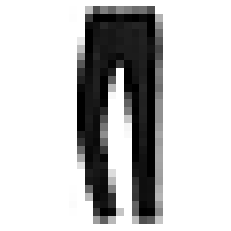

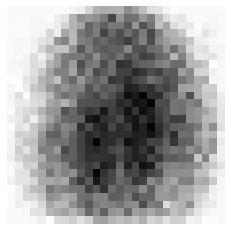

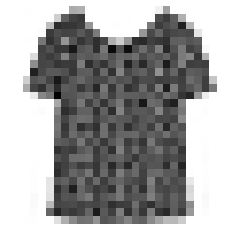

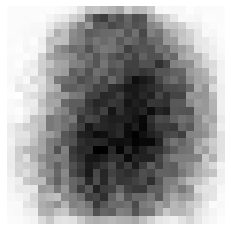

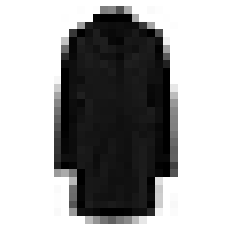

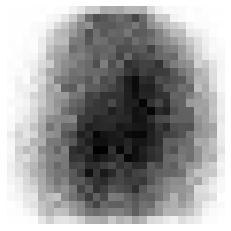

In [105]:
encoder = keras.models.Sequential([
    keras.layers.Dense(6, input_shape=[num_dimensiones]),
])

decoder = keras.models.Sequential([
    keras.layers.Dense(num_dimensiones, input_shape=[6]),
])

autoencoder = keras.models.Sequential([encoder, decoder])
autoencoder.compile(loss='mse', optimizer = keras.optimizers.SGD(lr=0.1))

# Si consideramos 3 imagenes, tenemos que:

imagen1 = X_sample.iloc[2]
imagen2 = X_sample.iloc[1000]
imagen3 = X_sample.iloc[1400]

def compareimage(some_garment):
    some_garment_image = some_garment.values.reshape(28,28)

    plt.imshow(some_garment_image, cmap='binary')
    plt.axis('off')
    plt.show()
    
    some_garment_std = sc.transform([some_garment])
    vector_autoencoded = decoder.predict(encoder.predict(some_garment_std))
    vector_no_std = sc.inverse_transform(vector_autoencoded)
    some_garment_image2 = vector_no_std[0].reshape(28,28)
    
    plt.imshow(some_garment_image2, cmap='binary')
    plt.axis('off')
    plt.show()
    
compareimage(imagen1)
compareimage(imagen2)
compareimage(imagen3)

In [122]:
def getautoencodedimages(images):
    images_std = sc.transform(images)
    history = autoencoder.fit(images_std,images_std, epochs=100,validation_data=(images_std,images_std),
                         callbacks=[keras.callbacks.EarlyStopping(patience=10)])
    return encoder.predict(X_std)
    
X_reducido = getautoencodedimages(X_sample)

Epoch 1/100
313/313 [==============================] - 1s 2ms/step - loss: 0.4596 - val_loss: 0.4589
Epoch 2/100
313/313 [==============================] - 1s 2ms/step - loss: 0.4595 - val_loss: 0.4590
Epoch 3/100
313/313 [==============================] - 1s 2ms/step - loss: 0.4595 - val_loss: 0.4589
Epoch 4/100
313/313 [==============================] - 1s 2ms/step - loss: 0.4595 - val_loss: 0.4589
Epoch 5/100
313/313 [==============================] - 1s 2ms/step - loss: 0.4595 - val_loss: 0.4589
Epoch 6/100
313/313 [==============================] - 1s 2ms/step - loss: 0.4595 - val_loss: 0.4589
Epoch 7/100
313/313 [==============================] - 1s 2ms/step - loss: 0.4595 - val_loss: 0.4589
Epoch 8/100
313/313 [==============================] - 1s 2ms/step - loss: 0.4595 - val_loss: 0.4589
Epoch 9/100
313/313 [==============================] - 1s 2ms/step - loss: 0.4595 - val_loss: 0.4589
Epoch 10/100
313/313 [==============================] - 1s 2ms/step - loss: 0.4595 - val_lo

In [147]:
accu_red = np.mean(cross_val_score(clf, X_reducido, y_sample, cv=5, scoring='accuracy'))
print(accu_red)

0.6655


# Parte 2: Sampleo

Hacer fit de un modelo GMM

In [139]:
from sklearn.mixture import GaussianMixture

gmm = GaussianMixture(n_components=10, random_state=42)
y_pred = gmm.fit_predict(X_reducido)
y_pred

array([8, 5, 2, ..., 6, 2, 8], dtype=int64)

In [140]:
#Obtenemos la media y covarianza de estos con:

medias = gmm.means_
covarianzas = gmm.covariances_

Código para samplear de un cluster en particular

In [145]:
samples = []

for s in range(10):
    sample = np.random.multivariate_normal(medias[s],covarianzas[s])
    samples.append(sample)

print(samples)

[array([-0.39512161,  2.42176661, -0.96525881,  2.43956148,  2.3940479 ,
       -3.09792476]), array([ 1.52148555,  0.42594154,  7.6306297 , -6.18589942, -1.0386634 ,
        3.1890387 ]), array([ 4.51930969, -1.95474091,  0.22436647,  3.91353908,  2.88138472,
       -8.4316041 ]), array([  9.6911365 ,  -6.42776407, -11.49833674,   8.33964948,
       -11.27331902,   7.26647237]), array([-1.90778881, -8.15045877, -3.10150264,  3.35810907, -8.53361058,
        4.10742957]), array([-2.36365863, -3.26346989, -8.62120715, -4.8182304 ,  6.50388457,
        9.41764433]), array([-8.16542699, -2.59453653, -0.64110702,  3.35793987,  0.10557676,
       -1.60501254]), array([ 4.92340737,  4.63841553, -0.45298975,  3.56238238,  0.71972362,
       -6.48618951]), array([-6.5667336 , -5.33248375,  6.63545738, -2.30365648, -2.11054931,
       -1.90308811]), array([-2.89213535, -0.52902935, -3.35189862, -1.48546047,  2.78258668,
        0.20606785])]


# Parte 3: Comparación PCA/Autoencoder en base a samples

Analiza visualmente dos samples de cada clase (toma dos samples de cada clase, decodifica, des-estandariza y grafica como mostramos en la parte de datos)

In [148]:
twosamples = []
twosamples.append(samples[0])
twosamples.append(samples[1])

Analiza visualmente la meda

¿qué clústeres parece entregar consistentemente prendas de un tipo en específico? ¿qué prendas son?

Entrena un clasificador de randomforest con los datos originales. 

Samplea y decodifica 50 ejemplos de cada cluster identificado por GMM, y entrégaselos al randomforest. Ahora ve los resultados de las predicciones. Vé si son consistentes en el sentido de que predicen que una buena cantidad de los ejemplos de los dos clústeres que identificaste son de una prenda en particular. 